### Import libraries

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [70]:
from util import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
set_gpu_limit(6)

### Split none onehot encoded data into train and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.1,random_state=2020)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=0.11,random_state=2020)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model          99186 non-null  object
 1   price          99186 non-null  int64 
 2   transmission   99186 non-null  object
 3   fuelType       99186 non-null  object
 4   binned_year    99186 non-null  int64 
 5   mil_cat        99186 non-null  int64 
 6   binned_mpg     99186 non-null  int64 
 7   engine_binned  99186 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


### We will embed columns model, transmission, and fuelType

--- 

### Garbage collect

In [7]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Setting up some constants

In [57]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [55]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### train, dev, and test data for NN

* model embed model input 
* transmission embed model input
* fuelType embed model input 
* numeric input data 

In [45]:
train_input,dev_input,test_input = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [59]:
base_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr)

In [61]:
base_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 4)]          0                                            
____________________________________________________________________________________________

In [63]:
history = base_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
                         verbose = 1, validation_data=(dev_input,y_dev),
                         callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 23234084.0000 - MAPE: 18.9922 - MAE: 2865.2595 - val_loss: 15999433.0000 - val_MAPE: 14.0836 - val_MAE: 2257.2129
Epoch 2/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 12314806.0000 - MAPE: 14.4076 - MAE: 2206.4858 - val_loss: 14066964.0000 - val_MAPE: 12.6603 - val_MAE: 2117.2979
Epoch 3/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 11575377.0000 - MAPE: 13.9658 - MAE: 2141.0295 - val_loss: 13139790.0000 - val_MAPE: 12.8754 - val_MAE: 2053.0361
Epoch 4/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 10915142.0000 - MAPE: 13.3426 - MAE: 2072.0518 - val_loss: 12552828.0000 - val_MAPE: 12.3999 - val_MAE: 1997.4611
Epoch 5/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 10657033.0000 - MAPE: 13.2283 - MAE: 2060.4426 - val_loss: 13171222.0000 - val_MAPE: 12.9008 - val_MAE: 2102.7529
Epoch 6/1000
2483/2483 [================

Epoch 44/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6908426.5000 - MAPE: 11.1661 - MAE: 1729.7015 - val_loss: 8676621.0000 - val_MAPE: 10.1884 - val_MAE: 1685.4243
Epoch 45/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6817645.0000 - MAPE: 11.2264 - MAE: 1730.4863 - val_loss: 8575026.0000 - val_MAPE: 10.4592 - val_MAE: 1708.1805
Epoch 46/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6955186.5000 - MAPE: 11.2452 - MAE: 1741.8553 - val_loss: 8859546.0000 - val_MAPE: 10.7955 - val_MAE: 1752.2535
Epoch 47/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6873877.0000 - MAPE: 11.1790 - MAE: 1728.3131 - val_loss: 8739105.0000 - val_MAPE: 10.0764 - val_MAE: 1672.2755
Epoch 48/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6720395.0000 - MAPE: 11.1660 - MAE: 1720.2180 - val_loss: 8594055.0000 - val_MAPE: 10.8636 - val_MAE: 1706.8455
Epoch 49/1000
2483/2483 [====================

In [64]:
base_embed_model.save("cate_embed_base_model.h5")

In [65]:
base_embed_model = tfk.models.load_model("cate_embed_base_model.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

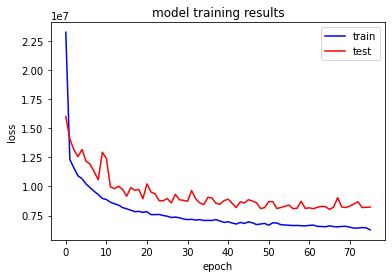

In [66]:
plot_metrics(history,"loss")

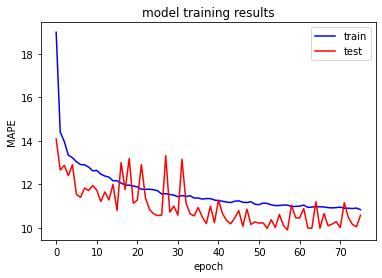

In [67]:
plot_metrics(history,"MAPE")

In [68]:
regression_metrics(base_embed_model,train_input,y_train,test_input,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.943838,2337.606449,695.343624
test,0.937741,2406.883565,408.698918


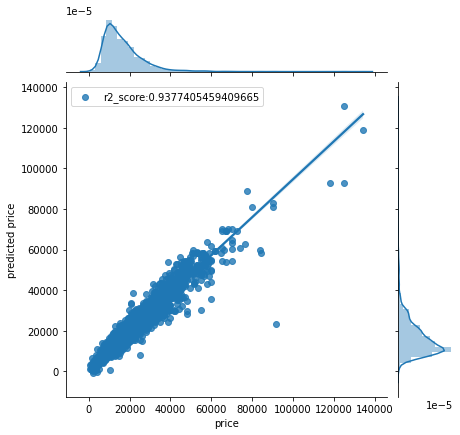

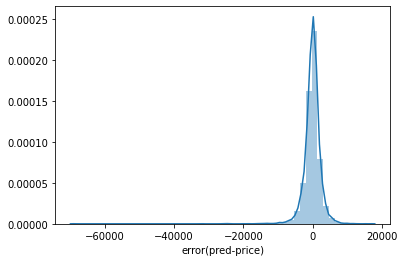

In [69]:
plot_pred_price(base_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [72]:
price_table = price_diff(base_embed_model,X_test,y_test,256, 1, test_input)

In [73]:
price_table.sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
39978,A Class,Manual,Petrol,1,5,1,0,-408.698918,408.698918
40171,A Class,Automatic,Petrol,1,4,2,0,-251.181017,251.181017
20056,Beetle,Manual,Petrol,1,4,2,0,-191.598764,191.598764
12301,Golf,Manual,Petrol,2,4,2,0,-172.129982,172.129982
2450,Yaris,Automatic,Petrol,0,4,2,0,155.427723,155.427723
85142,Z4,Automatic,Petrol,1,4,1,1,-126.068407,126.068407
98752,A6,Automatic,Diesel,2,4,2,1,-113.813571,113.813571
44326,Corsa,Manual,Petrol,1,5,2,0,105.695672,105.695672
39953,SLK,Automatic,Petrol,0,5,1,1,103.857876,103.857876
98626,TT,Manual,Petrol,1,5,1,0,-97.500380,97.500380
